In [1]:
import re #regex
import os #operating system
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt


In [2]:
directory = 'csv/perf_only_algorithm'
files = []
for filename in os.listdir(directory):
    file_path = os.path.join(directory, filename)
    if (re.match("^fwa_dev_v_.*", filename)) and (not re.match("^fwa_dev_v_.*_pitch.*", filename)):
      files.append(file_path)
      print(file_path)

csv/perf_only_algorithm/fwa_dev_v_1_1__n_080__b_08__t_01.csv
csv/perf_only_algorithm/fwa_dev_v_1_1__n_080__b_16__t_01.csv
csv/perf_only_algorithm/fwa_dev_v_1_1__n_160__b_08__t_01.csv
csv/perf_only_algorithm/fwa_dev_v_1_1__n_160__b_16__t_01.csv
csv/perf_only_algorithm/fwa_dev_v_1_1__n_160__b_32__t_01.csv
csv/perf_only_algorithm/fwa_dev_v_1_1__n_240__b_08__t_01.csv
csv/perf_only_algorithm/fwa_dev_v_1_1__n_240__b_16__t_01.csv
csv/perf_only_algorithm/fwa_dev_v_1_1__n_240__b_24__t_01.csv
csv/perf_only_algorithm/fwa_dev_v_1_1__n_320__b_08__t_01.csv
csv/perf_only_algorithm/fwa_dev_v_1_1__n_320__b_16__t_01.csv
csv/perf_only_algorithm/fwa_dev_v_1_1__n_320__b_32__t_01.csv
csv/perf_only_algorithm/fwa_dev_v_1_1__n_400__b_08__t_01.csv
csv/perf_only_algorithm/fwa_dev_v_1_1__n_400__b_16__t_01.csv
csv/perf_only_algorithm/fwa_dev_v_1_1__n_480__b_08__t_01.csv
csv/perf_only_algorithm/fwa_dev_v_1_1__n_480__b_16__t_01.csv
csv/perf_only_algorithm/fwa_dev_v_1_1__n_480__b_24__t_01.csv
csv/perf_only_algorithm/

In [3]:
# for filename in files :
#     f = open(filename, "r")
#     print(f.read())
#     f.close()

In [4]:
def obtain_parameter(in_string, par_name) :
    par_regex = "-" + par_name + "=[^ \n]*"
    par_string = re.search(par_regex, in_string).group()
    par_value = re.sub(".*=", "", par_string)
    return par_value

def obtain_version(in_string) :
    par_regex = "v_[^. ]*"
    par_string = re.search(par_regex, in_string).group()
    par_value = re.sub("v_", "", par_string)
    return par_value

In [5]:
def obtain_all_parameters(in_file) :
    with open(in_file) as fp :
      for i, line in enumerate(fp) :
        if i == 0 :
            n = int(obtain_parameter(line, "n"))
            b = int(obtain_parameter(line, "b"))
            t = int(obtain_parameter(line, "t"))
            s = int(obtain_parameter(line, "s"))
            version = obtain_version(line)

        elif i == 3 :
            headers = line.replace('"', '').replace("\n", "").split(",")

        elif i == 4 :
            temp = line.replace("\n", "").replace("%", "").split(",")
            unit_measures = []
            for unit in temp :
              if unit != "" :
                unit = "(" + unit + ")"
              unit_measures.append(unit)

        elif i > 4 :
            break

    headers = list(map(lambda x, y: x + y, headers, unit_measures))

    return n, b, t, s, version, headers

In [6]:
df_nvprof_big = pd.DataFrame()     # collects all data
df_nvprof = pd.DataFrame()   # sums up everything
for filename in files : 
    #print(filename)
    n, b, t, s, version, headers = obtain_all_parameters(filename)
    time = headers[2]
    temp_df_big = pd.read_csv(filename, skiprows=5, names=headers)
    temp_df_big['version'] = version
    temp_df_big['n'] = n
    temp_df_big['b'] = b
    temp_df_big['tests'] = t
    temp_df_big['seed'] = s
    if df_nvprof.empty :
      df_nvprof_big = pd.DataFrame(columns = headers)
      df_nvprof = pd.DataFrame(columns = ['version', 'n', 'b', 'tests', 'seed', time])
    df_nvprof_big = pd.concat([df_nvprof_big, temp_df_big])
    tot_time = temp_df_big[time].sum()
    #print(f"version = {version}, n = {n}, b = {b}, t = {t}, tot_time = {tot_time:.2f}")
    df_nvprof.loc[-1] = [version, n, b, t, s, tot_time]  # adding a row
    df_nvprof.index = df_nvprof.index + 1  # shifting index
    df_nvprof = df_nvprof.sort_index()  # sorting by index
df_nvprof = df_nvprof.sort_values(by = ['n', 'b', 'seed', 'tests', time])


In [7]:
#GPU, API in detail
print(df_nvprof_big)

              Type    Time(%)  Time(us) Calls Avg(us) Min(us)   Max(us)  \
0   GPU activities  99.858875  5207.861  1000   5.207   4.032      6.24   
1   GPU activities   0.080994     4.224     1   4.224   4.224     4.224   
2   GPU activities   0.060132     3.136     1   3.136   3.136     3.136   
3        API calls  73.537926  5784.505  1000   5.784    3.35  1477.008   
4        API calls  20.315443  1598.016    30  53.267   6.791   149.582   
..             ...        ...       ...   ...     ...     ...       ...   
14       API calls   0.041371    33.436     1  33.436  33.436    33.436   
15       API calls   0.011961     9.667     1   9.667   9.667     9.667   
16       API calls   0.008627     6.972     1   6.972   6.972     6.972   
17       API calls   0.007554     6.105     1   6.105   6.105     6.105   
18       API calls   0.001896     1.532     1   1.532   1.532     1.532   

                                                 Name version      n     b  \
0   execute_round_dev

In [8]:
#total sum per each (version,n,b,seed)
print(df_nvprof)

#with pd.option_context('display.max_rows', None, 'display.max_columns', None):  # more options can be specified also
#    print(df_nvprof)

    version    n   b  tests     seed    Time(us)
118     1_2   80   8      1  3381407    2494.095
101     1_3   80   8      1  3381407    2500.220
50      2_2   80   8      1  3381407    2563.124
67      2_0   80   8      1  3381407    2603.050
84      1_4   80   8      1  3381407    2653.635
..      ...  ...  ..    ...      ...         ...
68      1_4  480  32      1  3381407   16782.957
17      3_1  480  32      1  3381407   18082.927
102     1_2  480  32      1  3381407   20189.687
0       3_2  480  32      1  3381407   91243.240
119     1_1  480  32      1  3381407  429439.046

[136 rows x 6 columns]


In [9]:
df_chrono = pd.read_csv('csv/all_performances.csv')
df_chrono['Mean Squared Error(ms)'] = df_chrono['Mean Squared Error(ms)']
df_chrono['Mean Squared Error(%)'] = df_chrono['Mean Squared Error(%)'].str.strip('%').astype(float) / 100
print(df_chrono)

    version    n   b   t     Time(ms)  Mean Squared Error(ms)  \
0       3_1   80   8  10     2.753003                4.231900   
1       3_1   80  16  10     1.726733                2.544996   
2       3_1  160   8  10     3.910260                2.607584   
3       3_1  160  16  10     2.907390                2.601808   
4       3_1  160  32  10     2.483720                2.588644   
..      ...  ...  ..  ..          ...                     ...   
148     1_1  400  16  10   180.290888                2.603372   
149     1_1  480   8  10  1070.825976                5.475736   
150     1_1  480  16  10   326.593678                2.616768   
151     1_1  480  24  10   246.054136                3.456455   
152     1_1  480  32  10   219.230310                2.558435   

     Mean Squared Error(%)  
0                 1.537194  
1                 1.473879  
2                 0.666857  
3                 0.894895  
4                 1.042245  
..                     ...  
148             

In [10]:
na_columns = df_nvprof_big.columns[df_nvprof_big.isna().any()].tolist()
if na_columns == [] :
    print("No NaN values found")
else :
    print("Columns with NaN:")
    print(na_columns)

No NaN values found


In [11]:
versions_to_remove = ['1_1', '3_2']
versions = np.unique(df_nvprof['version'])
versions = versions.tolist()
versions = [ elem for elem in versions if elem not in versions_to_remove]
print(versions)

['1_2', '1_3', '1_4', '2_0', '2_2', '3_1']


In [12]:
def plot_perf_version(df, y_axis, analyzer, versions=versions) :
    rows = 2
    cols = 2
    fig, axis = plt.subplots(rows, cols, figsize=(15, 10))
    idx = 0
    df_filtered = df[df['version'].isin(versions)]
    fig.suptitle("Performance of versions with " + analyzer,  fontsize=16)
    max_y = max(df_filtered[y_axis])
    for b in range(8, 33, 8):
        i = (int) (idx / cols)
        j = (int) (idx % cols)
        df_plot = df_filtered[(df_filtered['b'] == b)]
        for label, grp in df_plot.groupby(['version']):
            sub_title = "B = " + str(b)
            grp.plot(ax=axis[i][j], kind='line', x='n', y=y_axis, xlabel='Matrix Size', ylabel=y_axis, label=label, title=sub_title, ylim=(0,max_y), marker='o')
        idx += 1

    out_filename = 'png/versions_performance_' + analyzer + '.png'
    plt.savefig(out_filename, facecolor='white', transparent=False)

In [13]:
def plot_perf_B(df, y_axis, analyzer, versions=versions) :
    rows = 2
    cols = 4
    fig, axis = plt.subplots(rows, cols, figsize=(25, 10))
    idx = 0
    df_filtered = df[df['version'].isin(versions)]
    fig.suptitle("Performance of blocking factors with " + analyzer,  fontsize=16)
    max_y = max(df_filtered[y_axis])
    for v in versions:
        i = (int) (idx / cols)
        j = (int) (idx % cols)
        df_plot = df_filtered[(df_filtered['version'] == v)]
        for label, grp in df_plot.groupby(['b']):
            sub_title = "version = " + v
            grp.plot(ax=axis[i][j], kind='line', x='n', y=y_axis, xlabel='Matrix Size', ylabel=y_axis, label=label, title=sub_title, ylim=(0,max_y), marker='o')
        idx += 1

    out_filename = 'png/blocking_factors_performance_' + analyzer + '.png'
    plt.savefig(out_filename, facecolor='white', transparent=False)

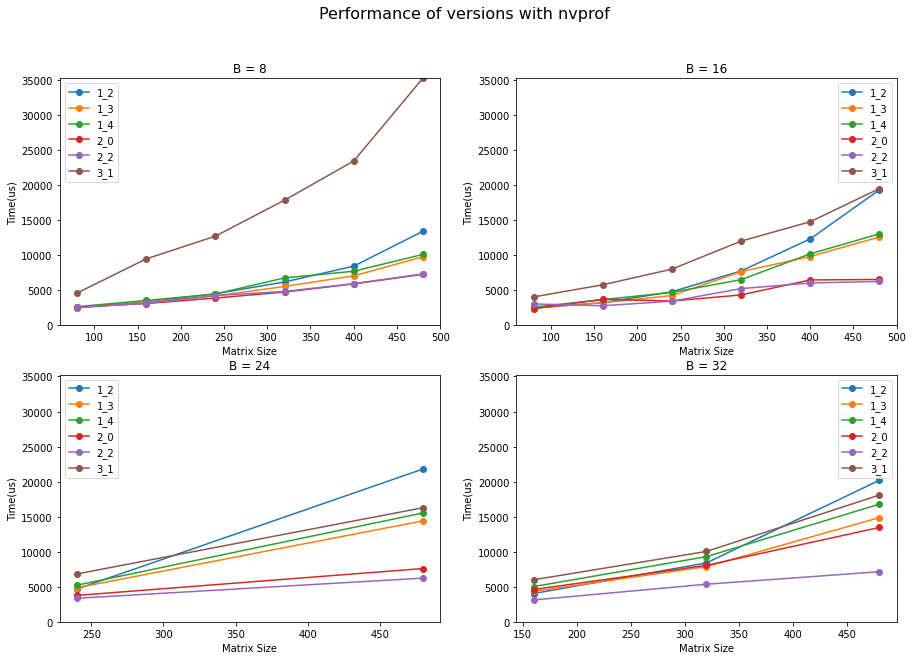

In [14]:
plot_perf_version(df_nvprof, time, 'nvprof')

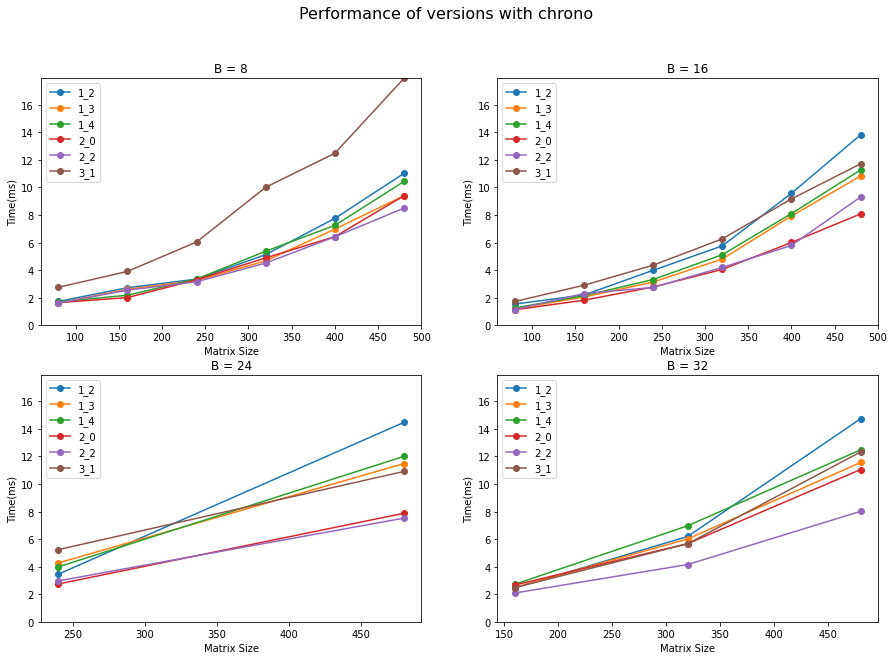

In [15]:
plot_perf_version(df_chrono, 'Time(ms)', 'chrono')

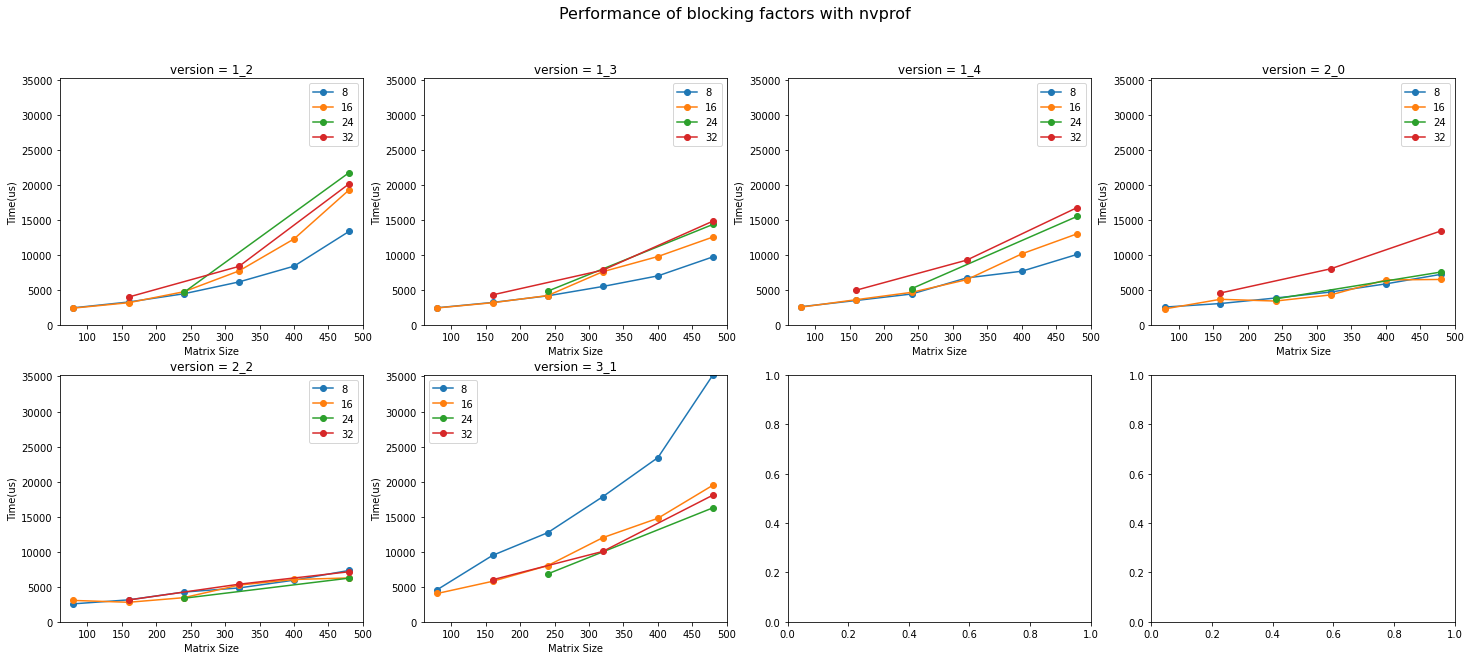

In [16]:
plot_perf_B(df_nvprof, time, 'nvprof')

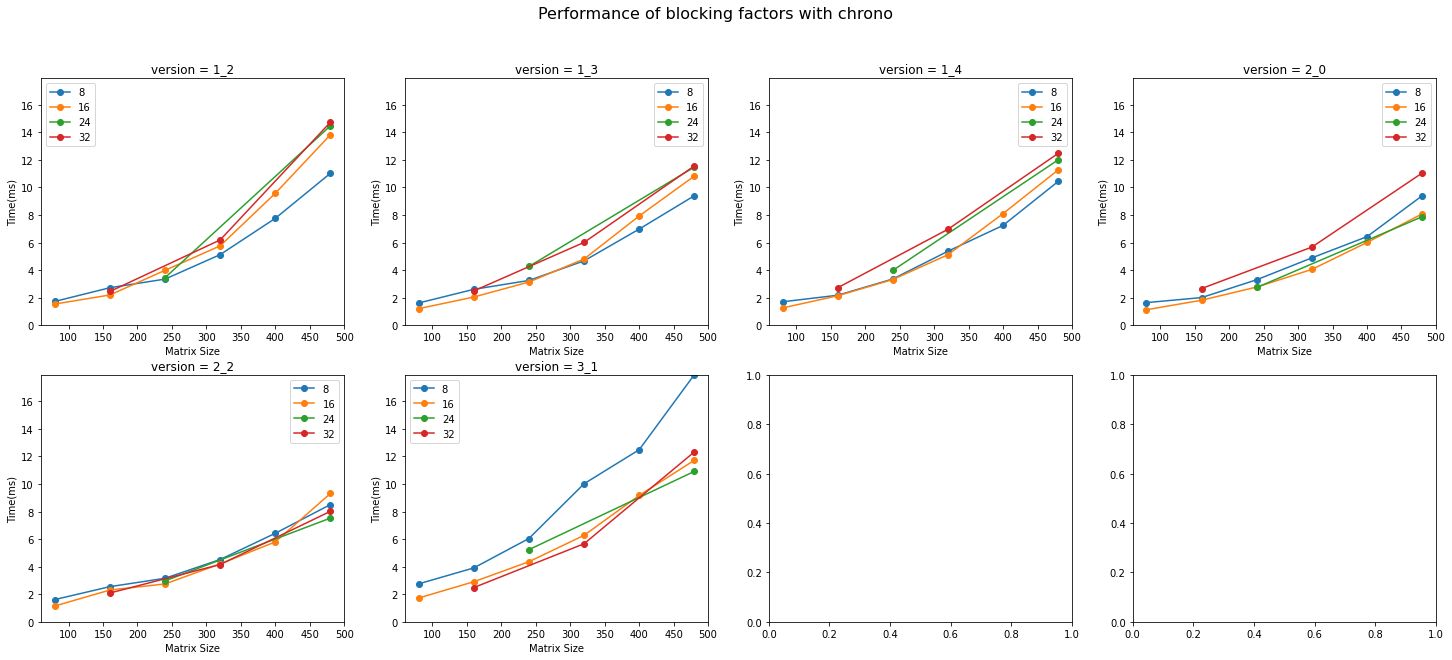

In [17]:
plot_perf_B(df_chrono, 'Time(ms)', 'chrono')

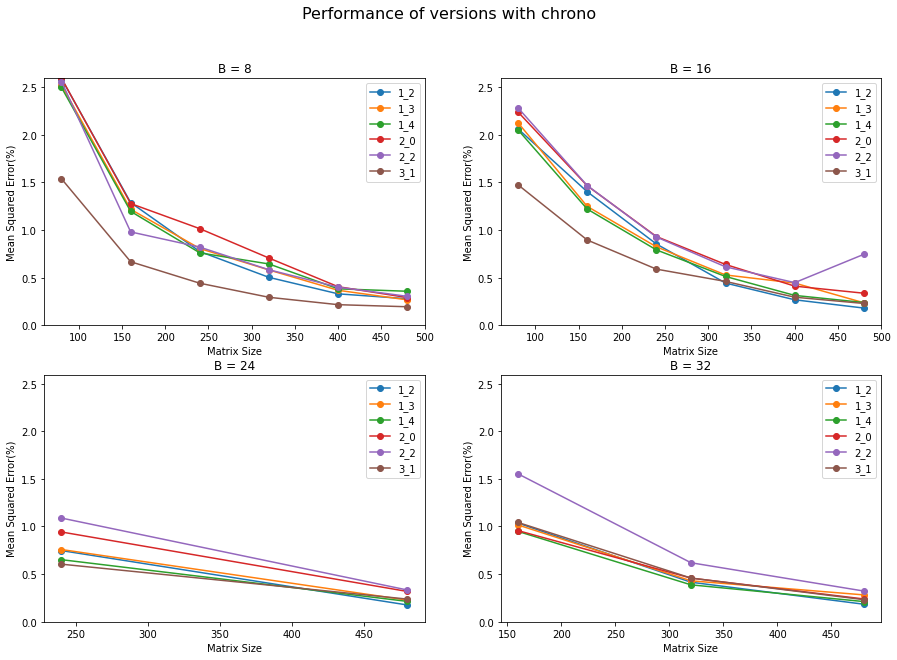

In [18]:
plot_perf_version(df_chrono, 'Mean Squared Error(%)', 'chrono')

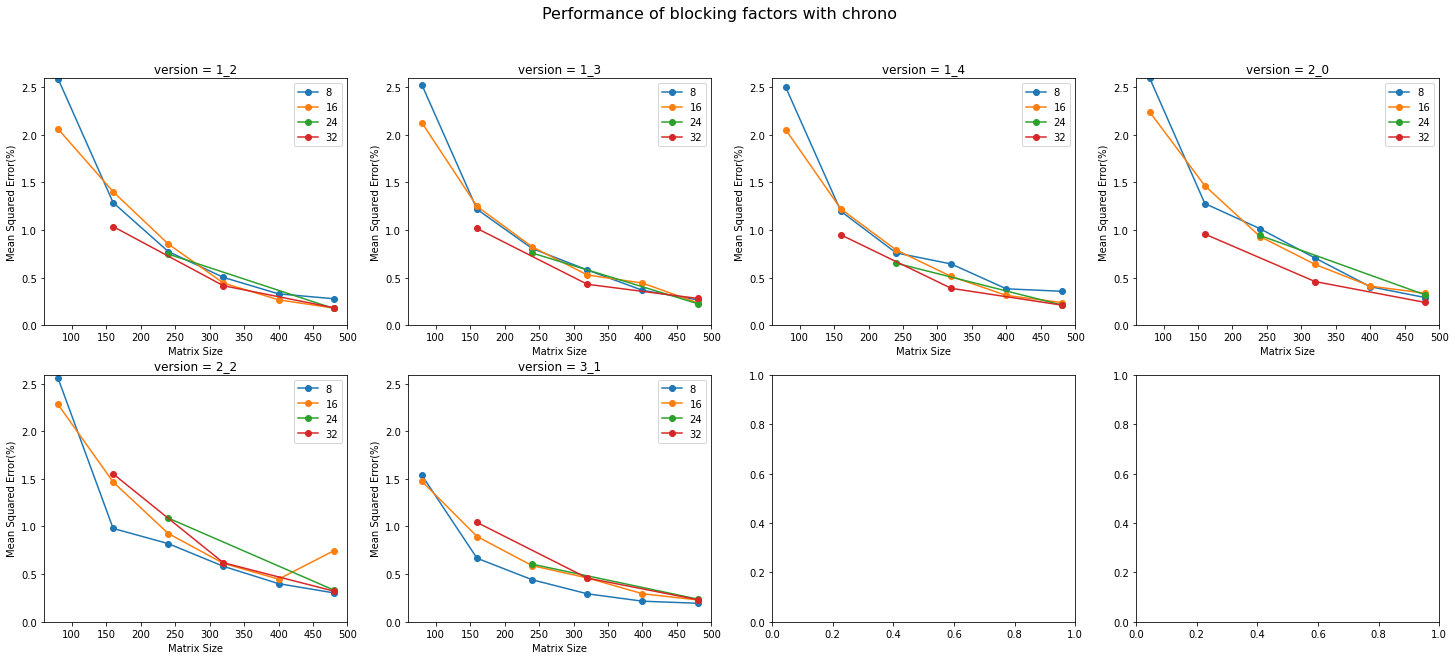

In [19]:
plot_perf_B(df_chrono, 'Mean Squared Error(%)', 'chrono')